In [1]:
library(svMisc)


Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
data <- read.table("./spectrum.dat")

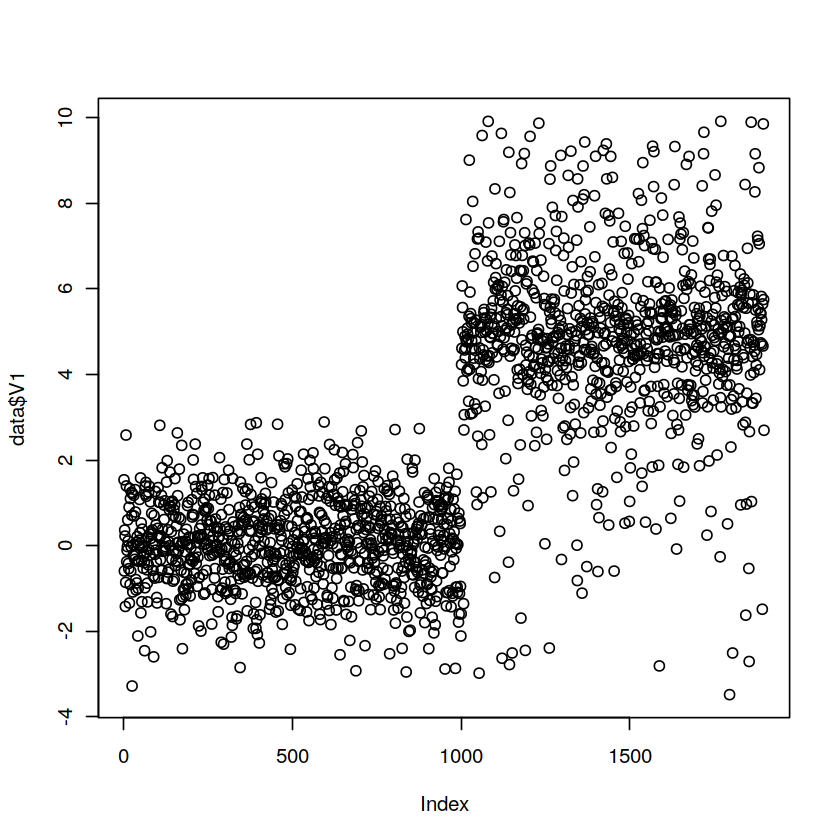

In [8]:
plot(data$V1)

In [2]:
#        # take care of repeated data
#         x_sorted = sort(x)
#         x_unique = [x_sorted[1]]
#         x_weight::Array{Int32} = [1]
#         for i in 2:length(x_sorted)
#             if x_sorted[i] == x_sorted[i-1]
#                 x_weight[end] += 1
#             else
#                 push!(x_unique, x_sorted[i])
#                 push!(x_weight, 1)
#             end
#         end
x_sorted <- sort(data$V1)
x_unique <- c(x_sorted[1])
x_weight <- c(1)
for (i in 2:length(x_sorted)){
    if (x_sorted[i] == x_sorted[i-1]){
        x_weight[length(x_weight)] <- x_weight[length(x_weight)] + 1
    }
    else {
        x_unique <- c(x_unique, x_sorted[i])
        x_weight <- c(x_weight, 1)
    }
}

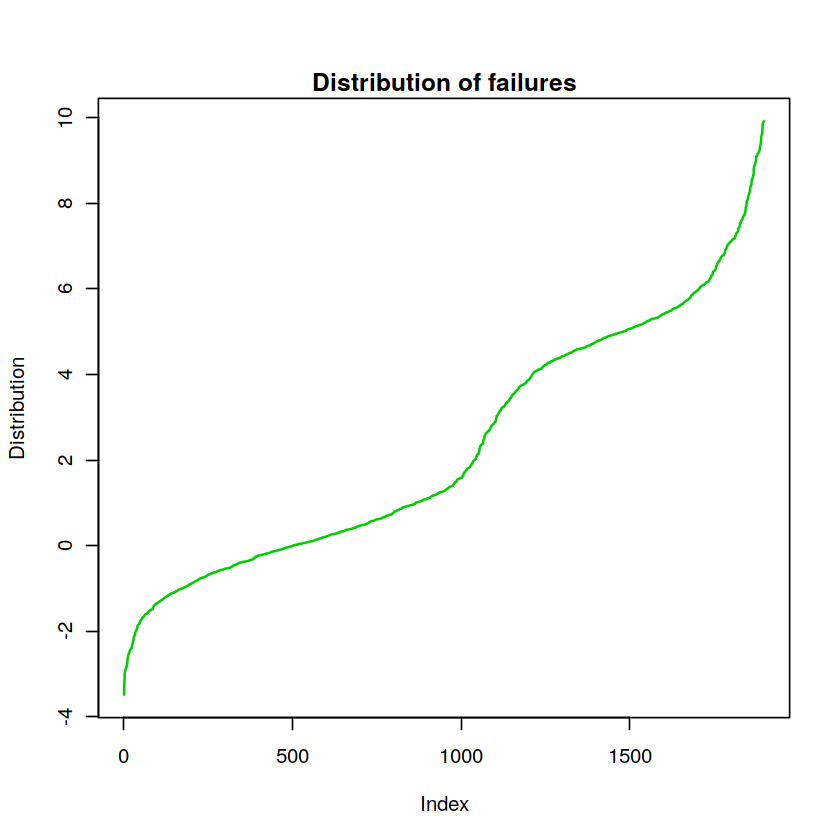

In [3]:
plot(x_unique, col=3, lwd=1.5, lty=1, type="l", ylab='Distribution')
title(main=paste("Distribution of failures"), line=0.3, cex.main=1.2)

In [4]:
# final number of data points
N = length(x_unique)
gamma = 0.01
p0 = 0.01

logf_dict <- function(N_k, T_k){
    return(N_k * log(N_k/T_k))
}

logp_dict <- list(gamma = function(g) log(g),
                  p0 = function(Np=N, p=p0) log(73.53 * p * Np^(-0.478)) - 4)
                  

# save prior value for later computation
ncp_prior = logp_dict$p0(p0)
ncp_prior

[1] -2.106205

In [5]:
x <- x_unique
# array of (all possible) block edges
edges <- c(x[1], 0.5*(x[1:(length(x)-1)] + x[2:length(x)]), x[length(x)])

edges[1:10]

[1] -3.485279 -3.384080 -3.132697 -2.968905 -2.941336 -2.906424 -2.878209
 [8] -2.861049 -2.832322 -2.797798

In [89]:
# define nice alias to mimic the notation used in [^1]
F <- function(r, k){
    return(logf_dict(sum(x_weight[r:k]), edges[k+1] - edges[r]) + ncp_prior)
}

In [15]:
install.packages("svMisc")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [90]:
best <- c()
last <- c()


for (k in 1:N){
    A <- c()
    for (r in 1:k){
        A <- c(A, F(r, k)+ if(r==1) 0 else best[r-1])
    }
    last <- c(last, which.max(A))
    best <- c(best, max(A, na.rm=TRUE))
    progress(k, N, progress.bar=TRUE)
    if (k == N) message("Done!")
}


Done!


In [96]:
#    # extract changepoints by iteratively peeling off the last block
#     cp = Number[]
#     i = N+1
#     while i != 0
#         push!(cp, i)
#         i = (i == 1 ? 0 : last[i-1])
#     end

#     return [edges[j] for j in cp[end:-1:1]]
# end

cp <- c()
i <- N + 1
while(i!=0){
    cp <- c(cp, i)
    i = (if(i == 1) 0 else last[i - 1])
}

y <- c()
for (j in cp[length(cp):-1:1]){
    y <- c(y, edges[j])
}


Warning message in length(cp):-1:1:
“numerical expression has 39 elements: only the first used”

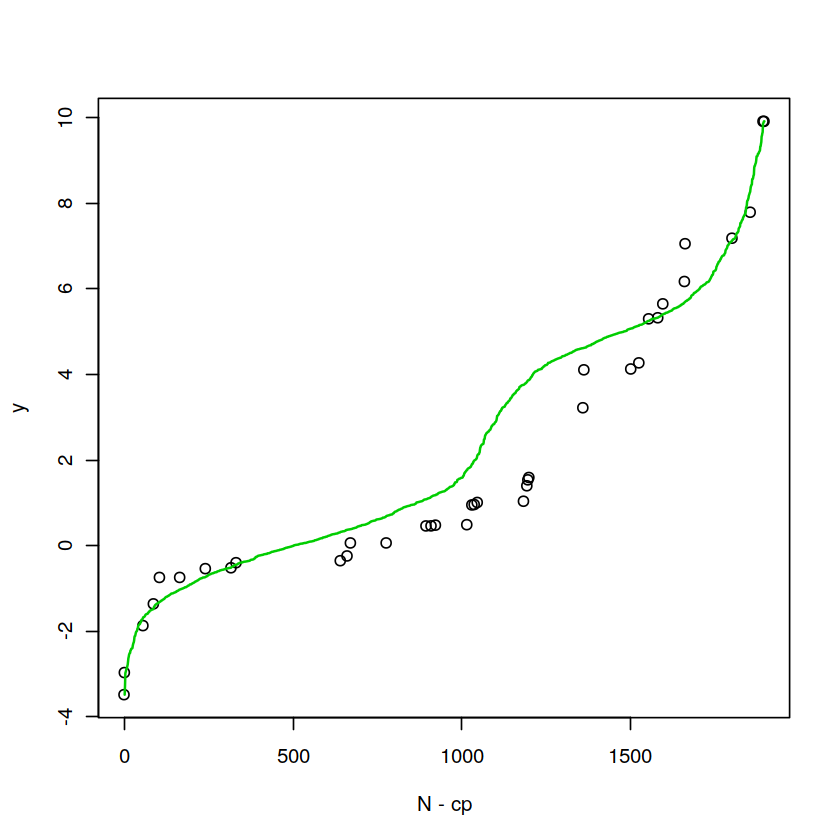

In [105]:
plot(N-cp, y)
lines(x_unique, col=3, lwd=1.5, lty=1, type="l")